In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import date
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from matplotlib import colors

### Create regression data

In [2]:
tfidf_path = '../../data/tfidf_toprev_conlen_full_v2/'

In [3]:
lda_path = '../../data/lda_jsd_toprev_conlen/'

In [91]:
fandom_list = ['harry_potter',
 'dcu',
 'doctor_who_&_related_fandoms',
 'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'supernatural',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'les_miserables_all_media_types',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
 'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'marvel',
 'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms']

In [92]:
def first_rel(field):
    try:
        return field.split(',')[0]
    except:
        return field

In [93]:
def find_major_rel(df):
    df['Relationship'] = df.apply(lambda row: first_rel(row['Relationship']), axis=1)
    counts = df['Relationship'].value_counts()
    return counts.keys()[0:5]


In [94]:
df_all = []
for i,fandom in enumerate(fandom_list):
    df_tfidf = pd.read_csv(os.path.join(tfidf_path,fandom + '_temporal_tfidf_cos_toprev_conlen.tsv'), sep = '\t')
    del df_tfidf['index']
    df_lda = pd.read_csv(os.path.join(lda_path,fandom + '_temporal_lda_jsd_toprev_full.tsv'), sep = '\t')
    del df_lda['index']
    df = pd.merge(df_tfidf, df_lda, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
 'ChapterIndex', 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
 'Fandoms', 'Hits' ,'Kudos', 'Language', 'Notes' ,'PublishDate' ,'Rating',\
 'Relationship' ,'Summary' ,'Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')
    
    df['fandom_category'] = fandom
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].fillna(0, inplace=True)
    df['Kudos'].fillna(0, inplace=True)
    df['Bookmarks'].fillna(0, inplace=True)
    df['Comments'].fillna(0, inplace=True)

    # normalize by chapter number
    df['Kudos'] = df['Kudos']/df['Chapters'] 
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Kudos'].dropna()
    # log values
#     df['Kudos'] = np.log(df['Kudos']+0.001)
#     df['Kudos'] = df['Kudos'].replace([np.inf, -np.inf], np.nan)
#     df['Kudos'].dropna()
    # z score
#     df['Kudos'] = (df['Kudos'] - df['Kudos'].mean())/df['Kudos'].std(ddof=0)
    
    df['Hits'] = df['Hits']/df['Chapters']
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Hits'].dropna()
#     df['Hits'] = np.log(df['Hits']+0.001)
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Hits'].dropna()
#     df['Hits'] = (df['Hits'] - df['Hits'].mean())/df['Hits'].std(ddof=0)
    
#     df['Comments'] = np.log(df['Comments']+1)
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Comments'].dropna()
#     df['Comments'] = (df['Comments'] - df['Comments'].mean())/df['Comments'].std(ddof=0)
    
    df['Bookmarks'] = df['Bookmarks']/df['Chapters']
    df = df.replace([np.inf, -np.inf], np.nan)
    df['Bookmarks'].dropna()
#     df['Bookmarks'] = np.log(df['Bookmarks']+0.001)
#     df = df.replace([np.inf, -np.inf], np.nan)
#     df['Bookmarks'].dropna()
#     df['Bookmarks'] = (df['Bookmarks'] - df['Bookmarks'].mean())/df['Bookmarks'].std(ddof=0)

    
    freq_rel = find_major_rel(df)
    df['Relationship'] = df['Relationship'].apply(lambda x: first_rel(x))
    df['Freq_relationship'] = df['Relationship'].apply(lambda x: 1 if x in freq_rel else 0)
    del df['Relationship']
    df_all.append(df)
    

In [95]:
df_all = pd.concat(df_all)

In [96]:
len(df_all)

609812

In [97]:
len(set(df_all.Author.tolist()))

86583

In [98]:
len(df_all[df_all.Kudos == 0])

10685

In [99]:
del df_all['Language']
del df_all['Notes']
del df_all['Summary']
del df_all['Title']
del df_all['URL']
del df_all['AdditionalTags']
del df_all['Fandoms']
del df_all['Characters']

In [100]:
df_all['Chapters'] = df_all['Chapters'].fillna(0)
df_all.Words = df_all.Words/df_all.Chapters

In [101]:
len(df_all)

609812

In [102]:
df_all['Category'].fillna('Unknown', inplace=True)
df_all['Category_F_F'] = df_all['Category'].apply(lambda x: 1 if 'F/F' in x else 0)
df_all['Category_F_M'] = df_all['Category'].apply(lambda x: 1 if 'F/M' in x else 0)
df_all['Category_Gen'] = df_all['Category'].apply(lambda x: 1 if 'Gen' in x else 0)
df_all['Category_M_M'] = df_all['Category'].apply(lambda x: 1 if 'M/M' in x else 0)
df_all['Category_Multi'] = df_all['Category'].apply(lambda x: 1 if 'Multi' in x else 0)
df_all['Category_Other'] = df_all['Category'].apply(lambda x: 1 if 'Other' in x else 0)
df_all['Category_Unknown'] = df_all['Category'].apply(lambda x: 1 if 'Unknown' in x else 0)
del df_all['Category']

In [103]:
df_all['ArchiveWarnings_underage'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Underage' in x else 0)
df_all['ArchiveWarnings_death'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Major Character Death' in x else 0)
df_all['ArchiveWarnings_choose_no'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Creator Chose Not To Use Archive Warnings' in x else 0)
df_all['ArchiveWarnings_no_apply'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'No Archive Warnings Apply' in x else 0)
df_all['ArchiveWarnings_violence'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Graphic Depictions Of Violence' in x else 0)
df_all['ArchiveWarnings_noncon'] = df_all['ArchiveWarnings'].apply(lambda x: 1 if 'Rape/Non-Con' in x else 0)

del df_all['ArchiveWarnings']

In [104]:
# df_all = df_all[df_all['ArchiveWarnings_blood'] != 1]
# df_all = df_all[df_all['ArchiveWarnings_none'] != 1]

In [105]:
df_all['ChapterIndex'].fillna(0, inplace=True)

In [106]:
df_all['Author'].fillna('Unknown', inplace=True)
counts = df_all['Author'].value_counts()
idx = counts[counts >= 10].index
df_all['author_fic_cnt'] = df_all['Author'].apply(lambda x: counts[x])
del df_all['Author']

In [107]:
df_all['Rating_E'] = df_all['Rating'].apply(lambda x: 1 if x == 'Explicit' else 0)
df_all['Rating_G'] = df_all['Rating'].apply(lambda x: 1 if x == 'General Audiences' else 0)
df_all['Rating_M'] = df_all['Rating'].apply(lambda x: 1 if x == 'Mature' else 0)
df_all['Rating_N'] = df_all['Rating'].apply(lambda x: 1 if x == 'Not Rated' else 0)
df_all['Rating_T'] = df_all['Rating'].apply(lambda x: 1 if x == 'Teen And Up Audiences' else 0)
del df_all['Rating']

In [108]:
df_all['Fandom_harry_potter'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'harry_potter' else 0)
df_all['Fandom_dcu'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'dcu' else 0)
df_all['Fandom_doctor_who'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'doctor_who_&_related_fandoms' else 0)
df_all['Fandom_star_wars'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'star_wars_all_media_types' else 0)
df_all['Fandom_arthurian'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'arthurian_mythology_&_related_fandoms' else 0)
df_all['Fandom_supernatural'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'supernatural' else 0)
df_all['Fandom_haikyuu'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'haikyuu' else 0)
df_all['Fandom_kuroko_no_basuke'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'kuroko_no_basuke' else 0)
df_all['Fandom_hamilton_miranda'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'hamilton_miranda' else 0)
df_all['Fandom_dragon_age'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'dragon_age_all_media_types' else 0)
df_all['Fandom_the_walking_dead'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'the_walking_dead_&_related_fandoms' else 0)
df_all['Fandom_buffy'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'buffy_the_vampire_slayer' else 0)
df_all['Fandom_les_miserables'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'les_miserables_all_media_types' else 0)
df_all['Fandom_naruto'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'naruto' else 0)
df_all['Fandom_tolkien'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'tolkien_j_r_r_works_&_related_fandoms' else 0)
df_all['Fandom_shakespare'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'shakespare_william_works' else 0)
df_all['Fandom_hetalia'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'hetalia_axis_powers' else 0)
df_all['Fandom_attack_on_titan'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'attack_on_titan' else 0)
df_all['Fandom_ms_paint_adventures'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'ms_paint_adventures' else 0)
df_all['Fandom_marvel'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'marvel' else 0)
df_all['Fandom_sailor_moon'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'bishoujo_senshi_sailor_moon' else 0)
df_all['Fandom_one_direction'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'one_direction' else 0)
df_all['Fandom_sherlock'] = df_all['fandom_category'].apply(lambda x: 1 if x == 'sherlock_holmes_&_related_fandoms' else 0)

del df_all['fandom_category']

In [109]:
def date_today(cell):
    try:
        y, m, d = cell.split('-')
        return abs(date.today() - date(int(y), int(m), int(d))).days
    except:
        return float('nan')

In [110]:
df_all['PublishDate'] = df_all.apply(lambda row: date_today(row['PublishDate']), axis = 1)
df_all['CompleteDate'] = df_all.apply(lambda row: date_today(row['CompleteDate']), axis = 1)
df_all['UpdateDate'] = df_all.apply(lambda row: date_today(row['UpdateDate']), axis = 1)

In [111]:
def find_history(field_list):
    field_list = [10000000 if np.isnan(x) else x for x in field_list]
    return np.amin(field_list)

In [112]:
df_all['history'] = df_all.apply(lambda row: find_history([row['PublishDate'], row['CompleteDate'], row['UpdateDate']]), axis=1)

In [113]:
del df_all['PublishDate']
del df_all['CompleteDate']
del df_all['UpdateDate']

In [114]:
len(df_all)

609812

In [115]:
# df_t = df_all.sample(100)
# for col in df_t.columns.values:
#     print(col)
#     print(df_t[col].tolist())
#     print()

In [116]:
# df1 = df_all[df_all.isnull().any(axis=1)]

In [117]:
df_all.columns.values

array(['Bookmarks', 'ChapterIndex', 'Chapters', 'Comments', 'Hits',
       'Kudos', 'Words', 'Cos', 'JSD', 'Freq_relationship',
       'Category_F_F', 'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_Unknown',
       'ArchiveWarnings_underage', 'ArchiveWarnings_death',
       'ArchiveWarnings_choose_no', 'ArchiveWarnings_no_apply',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon',
       'author_fic_cnt', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_N',
       'Rating_T', 'Fandom_harry_potter', 'Fandom_dcu',
       'Fandom_doctor_who', 'Fandom_star_wars', 'Fandom_arthurian',
       'Fandom_supernatural', 'Fandom_haikyuu', 'Fandom_kuroko_no_basuke',
       'Fandom_hamilton_miranda', 'Fandom_dragon_age',
       'Fandom_the_walking_dead', 'Fandom_buffy', 'Fandom_les_miserables',
       'Fandom_naruto', 'Fandom_tolkien', 'Fandom_shakespare',
       'Fandom_hetalia', 'Fandom_attack_on_titan',
       'Fandom_ms_paint_adventures', 

In [118]:
df_all = df_all.rename(columns = {'history':'History', 'Cos': 'Term_novelty', 'JSD': 'Topic_novelty'})

In [119]:
df_all.head()

,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Words,Term_novelty,Topic_novelty,Freq_relationship,...,Fandom_tolkien,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
0,3.000000,0.0,1,5,939.000000,49.000000,931.000000,0.887581,0.577307,0,...,0,0,0,0,0,0,0,0,0,5832.0
1,0.176471,13.0,17,0,122.705882,1.294118,2694.588235,0.342318,0.657559,0,...,0,0,0,0,0,0,0,0,0,4384.0
2,1.000000,0.0,1,0,626.000000,10.000000,700.000000,0.854178,0.581707,0,...,0,0,0,0,0,0,0,0,0,5826.0
3,2.000000,0.0,1,1,207.000000,6.000000,644.000000,0.807707,0.675777,0,...,0,0,0,0,0,0,0,0,0,5830.0
4,0.000000,0.0,1,0,70.000000,3.000000,852.000000,0.790260,0.679626,0,...,0,0,0,0,0,0,0,0,0,5831.0


In [ ]:
df_all = df_all[df_all.Kudos != 0]
df_all = df_all[df_all.Kudos != 0]
df_all = df_all[df_all.Kudos != 0]
df_all = df_all[df_all.Kudos != 0]

In [120]:
df_all.to_csv('fanfic_regression_data_curated.tsv', sep = '\t', index=False)

### Correlations

In [122]:
df_all = pd.read_csv('fanfic_regression_data_log.tsv', sep = '\t')

In [123]:
df_all = df_all.rename(columns = {'History': 'Age', 'author_fic_cnt':'Author fiction count',\
                                  'Term_novelty': 'Term novelty', 'Topic_novelty':'Topic novelty'})

In [124]:
term_ave = np.average(df_all['Term novelty'])
topic_ave = np.average(df_all['Topic novelty'])
df_all['Term novelty'] = df_all['Term novelty'] - term_ave
df_all['Topic novelty'] = df_all['Topic novelty'] - topic_ave
df_all['Term novelty squared'] = np.square(df_all['Term novelty'])
df_all['Topic novelty squared'] = np.square(df_all['Topic novelty'])

In [125]:
df_all.columns.values

array(['Bookmarks', 'ChapterIndex', 'Chapters', 'Comments', 'Hits',
       'Kudos', 'Words', 'Term novelty', 'Topic novelty',
       'Freq_relationship', 'Category_F_F', 'Category_F_M',
       'Category_Gen', 'Category_M_M', 'Category_Multi', 'Category_Other',
       'Category_Unknown', 'ArchiveWarnings_underage',
       'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
       'ArchiveWarnings_no_apply', 'ArchiveWarnings_violence',
       'ArchiveWarnings_noncon', 'Author fiction count', 'Rating_E',
       'Rating_G', 'Rating_M', 'Rating_N', 'Rating_T',
       'Fandom_harry_potter', 'Fandom_dcu', 'Fandom_doctor_who',
       'Fandom_star_wars', 'Fandom_arthurian', 'Fandom_supernatural',
       'Fandom_haikyuu', 'Fandom_kuroko_no_basuke',
       'Fandom_hamilton_miranda', 'Fandom_dragon_age',
       'Fandom_the_walking_dead', 'Fandom_buffy', 'Fandom_les_miserables',
       'Fandom_naruto', 'Fandom_tolkien', 'Fandom_shakespare',
       'Fandom_hetalia', 'Fandom_attack_on_titan',
     

In [126]:
corr = df_all[['Kudos','Bookmarks', 'Comments', 'Hits','Chapters', 'Words', 'Author fiction count', 'Term novelty', 'Topic novelty', 'Term novelty squared', 'Topic novelty squared','Age']].corr()

In [127]:
# corr = df_all[['Chapters',
#        'Term novelty', 'Topic novelty', 'Freq_relationship',
#        'Category_F_M', 'Category_Gen', 'Category_M_M', 'Category_Multi',
#        'Category_Other', 'Category_Unknown', 'ArchiveWarnings_underage',
#        'ArchiveWarnings_death', 'ArchiveWarnings_choose_no',
#        'ArchiveWarnings_no_apply', 'ArchiveWarnings_violence',
#        'ArchiveWarnings_noncon', 'Author fiction count', 'Rating_E', 'Rating_G',
#        'Rating_M', 'Rating_N', 'Rating_T', 'Fandom_harry_potter',
#        'Fandom_dcu', 'Fandom_doctor_who', 'Fandom_star_wars',
#        'Fandom_arthurian', 'Fandom_supernatural', 'Fandom_haikyuu',
#        'Fandom_kuroko_no_basuke', 'Fandom_hamilton_miranda',
#        'Fandom_dragon_age', 'Fandom_the_walking_dead', 'Fandom_buffy',
#        'Fandom_les_miserables', 'Fandom_naruto', 'Fandom_tolkien',
#        'Fandom_shakespare', 'Fandom_hetalia', 'Fandom_attack_on_titan',
#        'Fandom_ms_paint_adventures', 'Fandom_marvel',
#        'Fandom_sailor_moon', 'Fandom_one_direction', 'Fandom_sherlock',
#        'Age', 'Words']].corr()

In [128]:
w,v = np.linalg.eig(corr)  

In [129]:
for idx, item in enumerate(corr.columns.values):
    print(item, np.sqrt(max(w)/w[idx]))


Kudos 1.0
Bookmarks 1.2755044088768166
Comments 2.882907196555527
Hits 1.4232207783472044
Chapters 2.4688051972415352
Words 2.1723221094916827
Author fiction count 2.0404149636865765
Term novelty 1.7684493529240997
Topic novelty 1.7103230928545012
Term novelty squared 1.63832603033696
Topic novelty squared 1.5730295132704761
Age 1.5884561831213044


In [130]:
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


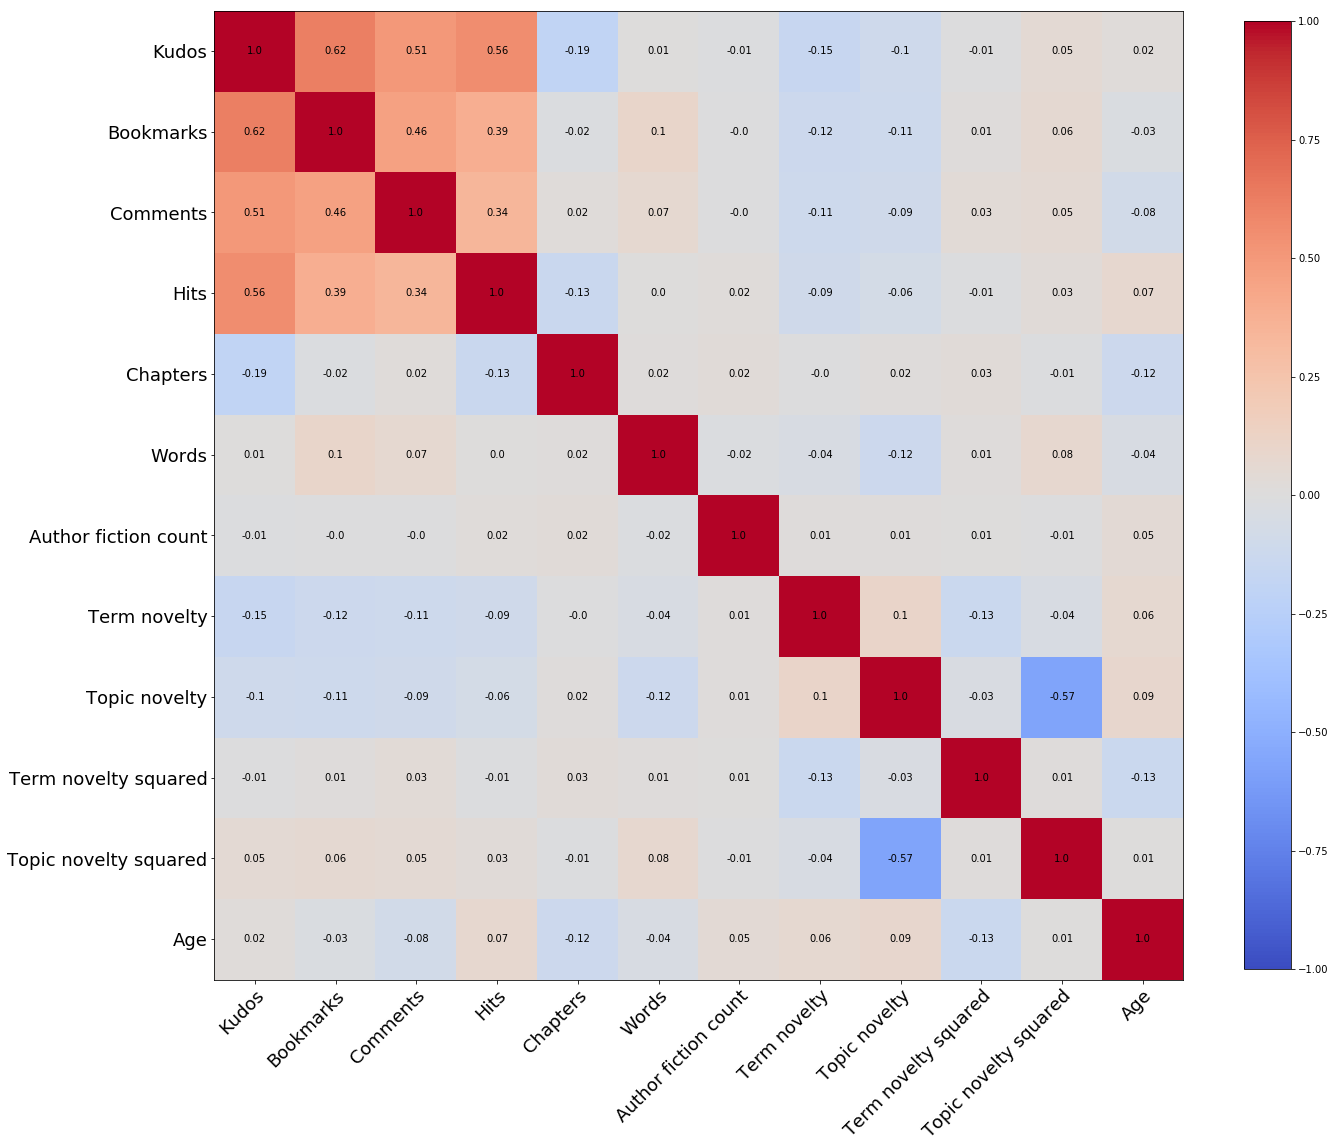

In [132]:
labels = corr.columns.values
fig, ax = plt.subplots(figsize = (20,20))

# kmin = np.amin(corr.as_matrix())
# kmax = np.amax(corr.as_matrix())

norm = colors.Normalize(vmin = -1, vmax = 1)
im = ax.imshow(corr, norm=norm,cmap='coolwarm')

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", fontsize='18')

plt.setp(ax.get_yticklabels(), fontsize='18')

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, round(corr.as_matrix()[i, j], 2),
                       ha="center", va="center", color="black")

ax.set_title("")
fig.colorbar(im, shrink=0.7)
fig.tight_layout()
plt.savefig('variables_corr.pdf', format='pdf')